# Implementation and Visualizations of Pinet and FSnet

In [1]:
import sys
import os

# Make sure the project root is on sys.path
project_root = os.path.abspath("../")  # adjust if notebook is in a subfolder
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    src = os.path.join(project_root, "src")
    sys.path.insert(0, src)

print("Added to sys.path:", project_root)
print("Added to sys.path:", src)

# Set WANDB offline if just want to run locally
# os.environ["WANDB_MODE"] = "offline"

Added to sys.path: /home/goiv/SafeGBPO_main_3/SafeGBPO
Added to sys.path: /home/goiv/SafeGBPO_main_3/SafeGBPO/src


## Pinet and Fsnet run

In [ ]:
from conf.envs import *
from conf.safeguard import *
from conf.learning_algorithms import *
from src.main import run_experiment, Experiment

import wandb
import torch
import optuna
import csv
from pathlib import Path

torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

wandb.login(key="") # Insert login key

experiment_queue = [
    Experiment(num_runs=1,
                learning_algorithm=SHACConfig(),
                env=NavigateSeekerConfig(safe_action_polytope=True),
                safeguard=PinetConfig(n_iter_admm=100, n_iter_bwd=5, fpi=True),
                interactions=100_000,
                eval_freq=5_000,
                fast_eval=False),
    Experiment(num_runs=1,
                learning_algorithm=SHACConfig(),
                env=NavigateSeekerConfig(safe_action_polytope=True),
                safeguard=FSNetConfig(),
                interactions=100_000,
                eval_freq=5_000,
                fast_eval=False),
]

csv_path = Path("src/runs_ids.csv")

# Create file and header ONLY if it does not exist
if not csv_path.exists():
    with open(csv_path, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["run_index", "safeguard", "wandb_run_id"])


for i, experiment in enumerate(experiment_queue):
    if experiment.num_runs == 0:
        print("[STATUS] Running hyperparameter search")
        study = optuna.create_study(direction="maximize",
                                    sampler=optuna.samplers.TPESampler(),
                                    pruner=optuna.pruners.HyperbandPruner(),
                                    storage=f"sqlite:///hyperparameters/{experiment.env.name}/study.sqlite3",
                                    study_name=experiment.learning_algorithm.name)

        pre_valued_objective = lambda trial: run_experiment(experiment, trial)
        study.optimize(pre_valued_objective, n_trials=100, n_jobs=1)
        print(f"Best value: {study.best_value} (params: {study.best_params})")

    else:
        print(f"[STATUS] Running experiment [{i + 1}/{len(experiment_queue)}]")
        for j in range(experiment.num_runs):
            print(f"  → Run {j + 1}/{experiment.num_runs}")

            _, run_id = run_experiment(experiment)

            # Save the run_id to download data from it later for visualizations
            with open(csv_path, mode="a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([j, experiment.safeguard.name if experiment.safeguard else "None", run_id])


### Extra Documentation for Pinet

**Implicit differentiation for ADMM fixed-point layer**

We consider an ADMM solver that produces s_k as a fixed point:

$$s_k = \text{ADMM}(s_k, a)$$

Define the implicit function:

$$F(s_k, a) = s_k - \text{ADMM}(s_k, a) = 0$$

We want the total derivative:

$$\frac{ds_k}{da}$$

By the implicit function theorem:

$$
\frac{ds_k}{da} = - \left(\frac{dF}{ds_k}\right)^{-1} \cdot \frac{dF}{da}
= \left(I - \frac{d\text{ADMM}(s_k, a)}{ds_k}\right)^{-1} \cdot \frac{d\text{ADMM}(s_k, a)}{da}
$$

Let the loss be L. By the chain rule:

$$
\frac{dL}{da} = \frac{dL}{da_{safe}} · \frac{da_{safe}}{ds_k} · \frac{ds_k}{da}
$$

Substitute the implicit derivative:

$$
\frac{dL}{da} = \frac{dL}{da_{safe}} · \frac{da_{safe}}{ds_k} · \left(I - \frac{d\text{ADMM}(s_k, a)}{ds_k}\right)^{-1} \cdot \frac{d\text{ADMM}(s_k, a)}{da}
$$

Define:

$$
v = \frac{dL}{da_{safe}} · \frac{da_{safe}}{ds_k}
$$

Then we solve the linear system:

$$
\left(I - \frac{d\text{ADMM}(s_k, a)}{ds_k}\right) g = v
$$

This can be done using:

- **Fixed-point iteration**:

$$
g_{k+1} = v + \frac{d\text{ADMM}(s_k, a)}{ds_k}^T g_k
$$

- **Or Anderson-style relaxed iteration**.

Finally, compute the gradient with respect to a:

$$
\frac{dL}{da} = g^T · \frac{d\text{ADMM}(s_k, a)}{da}
$$

**Implementation outline:**

1. Project upstream gradient to lifted space via zero-padding.
2. Compute $v = \frac{dL}{da_{safe}} · \frac{da_{safe}}{ds_k}$ via VJP.
3. Solve the linear system for g using JVP/VJP iterations.
4. Compute $\frac{d\text{ADMM}(s_k, a)}{da}$ via JVP and contract with g.
5. Return the gradient.


## FSnet

## Visualizations

### Result and Time Comparison Graphs

In [2]:
import pandas as pd
import wandb
from pathlib import Path
import numpy as np

# ------------------ CONFIG ------------------
CSV_PATH = Path("runs_ids.csv")
PROJECT_NAME = "Leveraging Analytical Gradients in Provably Safe Reinforcement Learning"
OUTPUT_CSV = Path("wandb_time_series.csv")
METRICS = ["eval/Average Reward", "performance_train/steps_per_second"]
# -------------------------------------------

def create_csv():
    assert CSV_PATH.exists(), f"{CSV_PATH} not found"

    # Read run IDs
    df_ids = pd.read_csv(CSV_PATH)
    run_ids = df_ids["wandb_run_id"].tolist()
    methods = df_ids["safeguard"].tolist()
    print(f"[INFO] Found {len(run_ids)} runs in runs_ids.csv")

    if OUTPUT_CSV.exists():
        df_existing = pd.read_csv(OUTPUT_CSV)
        existing_run_ids = set(df_existing["run_id"].unique())
        print(f"[INFO] Found {len(existing_run_ids)} runs already in {OUTPUT_CSV}")
    else:
        df_existing = None
        existing_run_ids = set()
        print(f"[INFO] {OUTPUT_CSV} does not exist yet. Will create it.")

    api = wandb.Api()
    all_new_rows = []

    for idx, (run_id, method) in enumerate(zip(run_ids, methods)):
        if run_id in existing_run_ids:
            print(f"[{idx + 1}/{len(run_ids)}] Skipping run {run_id} (already in CSV)")
            continue

        print(f"[{idx + 1}/{len(run_ids)}] Fetching run {run_id}")

        try:
            run = api.run(f"{PROJECT_NAME}/{run_id}")
        except wandb.errors.CommError as e:
            print(f"[WARNING] Could not load run {run_id}: {e}")
            continue

        history = run.history(keys=METRICS)

        if history is None or len(history) == 0:
            print(f"[WARNING] No history for run {run_id}")
            continue

        history["run_id"] = run.id
        history["Safeguard"] = method if isinstance(method, str) else "No Safeguard"

        cols = ["run_id", "Safeguard", "_step"] + METRICS
        history = history[cols]

        all_new_rows.append(history)

    if all_new_rows:
        df_new = pd.concat(all_new_rows, axis=0).reset_index(drop=True)

        if df_existing is not None:
            df_all = pd.concat([df_existing, df_new], axis=0).reset_index(drop=True)
        else:
            df_all = df_new

        df_all.to_csv(OUTPUT_CSV, index=False)
        print(f"[DONE] Added {len(df_new['run_id'].unique())} new runs to {OUTPUT_CSV}")
    else:
        print("[INFO] No new runs to add. Everything is already up to date.")

create_csv()

[INFO] Found 267 runs in runs_ids.csv
[INFO] Found 267 runs already in wandb_time_series.csv
[1/267] Skipping run ci1jab90 (already in CSV)
[2/267] Skipping run yglnimc5 (already in CSV)
[3/267] Skipping run wiyj6ayv (already in CSV)
[4/267] Skipping run 9l06u48e (already in CSV)
[5/267] Skipping run ry67tgnh (already in CSV)
[6/267] Skipping run xgiwneih (already in CSV)
[7/267] Skipping run h1cvcdvl (already in CSV)
[8/267] Skipping run 63s69d2t (already in CSV)
[9/267] Skipping run ek15uayd (already in CSV)
[10/267] Skipping run 8l1r5d3x (already in CSV)
[11/267] Skipping run j4z0g909 (already in CSV)
[12/267] Skipping run finserbk (already in CSV)
[13/267] Skipping run 2pscuap7 (already in CSV)
[14/267] Skipping run v3qv2i0p (already in CSV)
[15/267] Skipping run d0lker1h (already in CSV)
[16/267] Skipping run 1334lb2a (already in CSV)
[17/267] Skipping run lo1vy1zx (already in CSV)
[18/267] Skipping run v08z9stn (already in CSV)
[19/267] Skipping run s4s991uk (already in CSV)
[20/

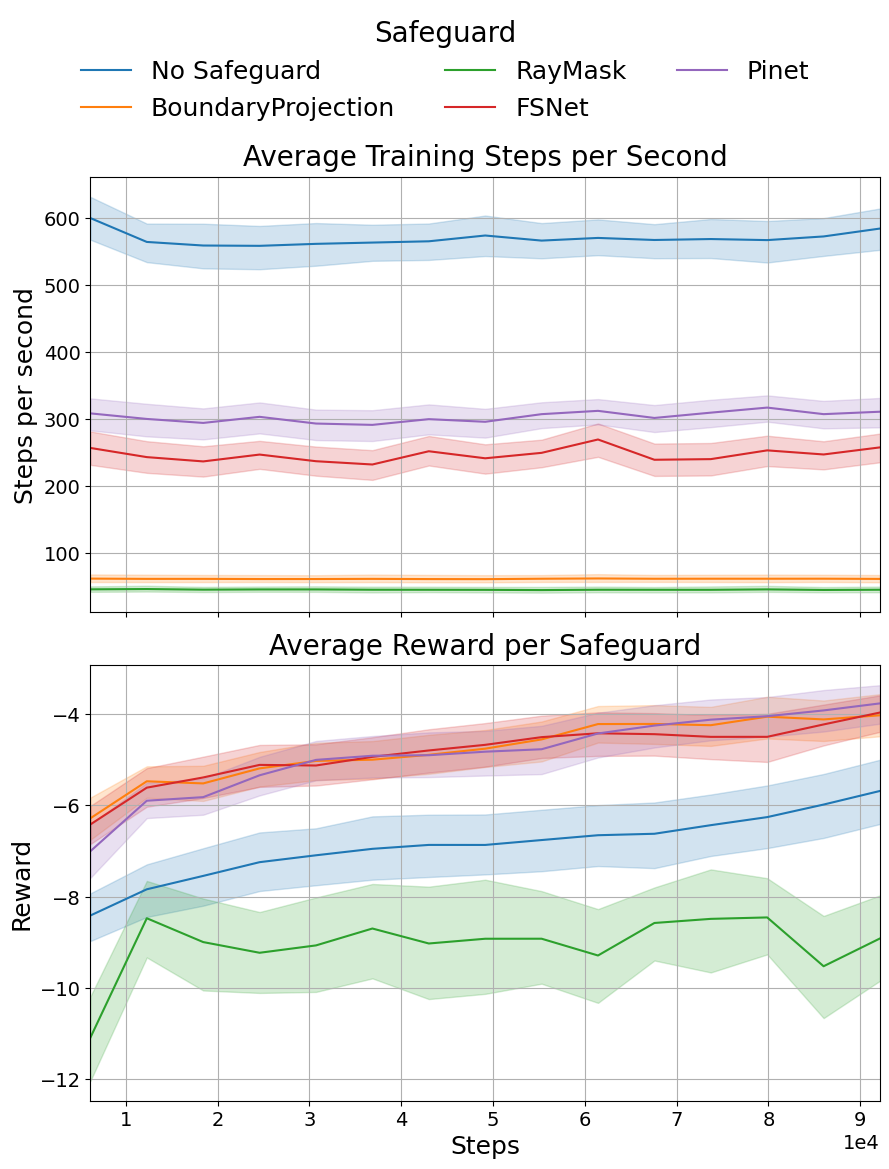

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load CSVs
df = pd.read_csv("wandb_time_series.csv")

first_step = min(df["_step"].min(), df["_step"].min())
last_step  = max(df["_step"].max(), df["_step"].max())

sns.color_palette("Dark2")

# Create stacked subplots
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(9, 11),
    sharex=True
)

# --------- TOP PLOT: Steps per second ---------
sns.lineplot(
    data=df,
    x="_step",
    y="performance_train/steps_per_second",
    hue="Safeguard",
    estimator="mean",
    errorbar=("ci", 95),
    lw=1.5,
    ax=ax1
)

ax1.set_xlim(first_step, last_step)
ax1.set_ylabel("Steps per second", fontsize=18)
ax1.set_title("Average Training Steps per Second", fontsize=20, pad=8)
ax1.grid(True)

# Remove legend from top plot (we'll use bottom one)
ax1.get_legend().remove()

# --------- BOTTOM PLOT: Reward ---------
sns.lineplot(
    data=df,
    x="_step",
    y="eval/Average Reward",
    hue="Safeguard",
    estimator="mean",
    errorbar=("ci", 95),
    lw=1.5,
    ax=ax2
)

ax2.set_xlim(first_step, last_step)
ax2.set_xlabel("Steps", fontsize=18)
ax2.set_ylabel("Reward", fontsize=18)
ax2.set_title("Average Reward per Safeguard", fontsize=20, pad=8)
ax2.grid(True)

# Scientific notation for shared x-axis
ax2.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# --------- Shared legend ---------
# --------- Shared legend at top ---------
handles, labels = ax2.get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Safeguard",
    title_fontsize=20,
    fontsize=18,
    loc="upper center",
    ncol=3,          # put entries in one row
    frameon=False,
    bbox_to_anchor=(0.5, 1.07)
)

# Remove seaborn legends from axes
ax2.get_legend().remove()

for ax in (ax1, ax2):
    ax.tick_params(axis='both', labelsize=14)
    ax.xaxis.get_offset_text().set_fontsize(14)

# Layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save
plt.savefig(
    "./combined_training_and_reward.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True
)

plt.show()


/home/saida_liu/miniconda3/envs/safegbpo/lib/python3.12/site-packages/torch/cuda/__init__.py:65: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Plotting: fsnet5_steps_viz.pt
Saved: fsnet_projection_clean.png / .svg


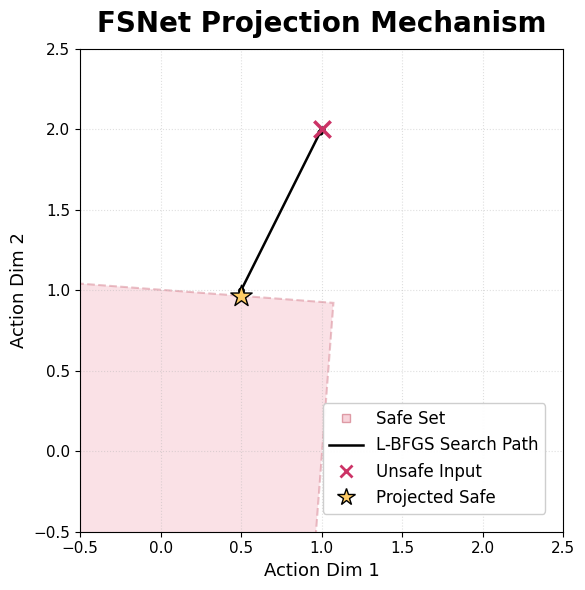

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull, HalfspaceIntersection
from scipy.optimize import linprog
from itertools import product
from pathlib import Path

# ==========================================
# 1. Geometry Helpers
# ==========================================

def get_zonotope_polygon(center, generators):
    if isinstance(center, torch.Tensor): center = center.detach().cpu().numpy()
    if isinstance(generators, torch.Tensor): generators = generators.detach().cpu().numpy()
    
    if center.ndim > 1: center = center[0]
    if generators.ndim > 2: generators = generators[0]
    
    c = center.flatten()
    G = generators
    n_gens = G.shape[1]
    
    coeffs = list(product([-1, 1], repeat=n_gens))
    vertices = []
    for coef in coeffs:
        delta = G @ np.array(coef)
        v = c + delta
        vertices.append(v)
    
    vertices = np.array(vertices)
    try:
        hull = ConvexHull(vertices)
        ordered_vertices = vertices[hull.vertices]
        return Polygon(ordered_vertices, closed=True)
    except Exception:
        return None

def get_polytope_polygon(A, b, interior_point=None):
    if isinstance(A, torch.Tensor): A = A.detach().cpu().numpy()
    if isinstance(b, torch.Tensor): b = b.detach().cpu().numpy()

    if A.ndim > 2: A = A[0]
    if b.ndim > 1: b = b[0]
    
    valid_mask = np.isfinite(b)
    A = A[valid_mask]
    b = b[valid_mask]
    
    if len(b) == 0: return None

    if interior_point is None:
        norm_A = np.linalg.norm(A, axis=1)
        c_obj = np.zeros(A.shape[1] + 1)
        c_obj[-1] = -1 
        A_ub = np.hstack([A, norm_A[:, np.newaxis]])
        res = linprog(c_obj, A_ub=A_ub, b_ub=b, bounds=(None, None), method='highs')
        if res.success and res.x[-1] > 1e-6: 
            interior_point = res.x[:-1]
        else:
            interior_point = np.zeros(A.shape[1]) 
    
    halfspaces = np.hstack((A, -b[:, np.newaxis]))

    try:
        hs = HalfspaceIntersection(halfspaces, interior_point)
        vertices = hs.intersections
        hull = ConvexHull(vertices)
        ordered_vertices = vertices[hull.vertices]
        return Polygon(ordered_vertices, closed=True)
    except Exception:
        return None

# ==========================================
# 2. Data Loader
# ==========================================

def load_list_data(filepath):
    path = Path(filepath)
    if not path.exists():
        for p in [Path("../" + path.name), Path(path.name)]:
            if p.exists():
                path = p
                break
        else:
            print(f"File not found: {filepath}")
            return None

    data = torch.load(path, map_location='cpu', weights_only=False)
    if not isinstance(data, list): data = [data]
    return data

# ==========================================
# 3. Plotting Function (FSNet / Clean)
# ==========================================

def plot_fsnet_projection_clean(filepath, step_idx=0, save=True):
    data_list = load_list_data(filepath)
    if not data_list: return

    data = data_list[min(step_idx, len(data_list)-1)]

    traj = data.get('trajectory') 
    unsafe = data.get('unsafe_action')
    
    if traj is None: return

    if traj.ndim == 3: traj = traj[:, 0, :]
    if unsafe.ndim == 2: unsafe = unsafe[0]

    traj = traj.detach().cpu().numpy()
    unsafe = unsafe.detach().cpu().numpy()
    
    # --- Check the trajectory ---
    # print(f"Trajectory shape: {traj.shape}")
    # print(f"Trajectory points:\n{traj}")
    
    # # Calculate distances between consecutive points to see if they are distinct
    # dists = np.linalg.norm(traj[1:] - traj[:-1], axis=1)
    # print(f"Step sizes: {dists}")
    # -----------------------------------

    # end = Final projected point
    end = traj[-1]

    # --- Style Config ---
    safe_fill = "#f3b6c2"       # Light Pink
    safe_edge = "#cc6677"       # Darker Pink
    path_color = "black"
    unsafe_color = "#cc3366"    # Magenta/Red
    projected_color = "#ffcc66" # Yellow/Orange

    fig, ax = plt.subplots(figsize=(6, 6))

    # 1. Safe Set
    poly = None
    if "safe_set_center" in data:
        poly = get_zonotope_polygon(data["safe_set_center"], data["safe_set_generators"])
    elif "safe_set_A" in data:
        poly = get_polytope_polygon(data["safe_set_A"], data["safe_set_b"], interior_point=end)

    if poly:
        poly.set_facecolor(safe_fill)
        poly.set_edgecolor(safe_edge)
        poly.set_alpha(0.4)
        poly.set_linewidth(1.5)
        poly.set_linestyle("--")
        ax.add_patch(poly)

    # 2. Solver Trajectory (Black line)
    # Plotting the whole path, but removing the specific 'start' marker
    ax.plot(traj[:, 0], traj[:, 1], "-o", color=path_color, lw=1.8, markersize=3.5)

    # 3. Points (Only Unsafe & Projected, NO Solver Init)
    
    # Unsafe Input (Red X)
    ax.scatter(unsafe[0], unsafe[1], marker="x", c=unsafe_color, s=140, linewidths=2.5, zorder=4)
    
    # Projected Safe (Yellow Star)
    ax.scatter(end[0], end[1], marker="*", c=projected_color, edgecolors="black", s=260, zorder=5)

    # --- Formatting ---
    ax.set_title("FSNet Projection Mechanism", fontsize=20, fontweight="bold", pad=12)
    ax.set_xlabel("Action Dim 1", fontsize=13)
    ax.set_ylabel("Action Dim 2", fontsize=13)
    ax.tick_params(labelsize=11)

    ax.set_aspect("equal")
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 2.5)
    ax.grid(True, linestyle=":", alpha=0.4)

    # --- Legend (Removed 'Projection Mapping' & 'Solver Init') ---
    legend_elements = [
        Line2D([0],[0], marker='s', color='w', markerfacecolor=safe_fill, markeredgecolor=safe_edge, alpha=0.6, label='Safe Set'),
        Line2D([0],[0], color='black', lw=1.8, label='L-BFGS Search Path'),
        Line2D([0],[0], marker='x', color=unsafe_color, lw=0, markersize=9, markeredgewidth=2, label='Unsafe Input'),
        Line2D([0],[0], marker='*', color=projected_color, markeredgecolor='black', lw=0, markersize=13, label='Projected Safe'),
    ]

    ax.legend(
        handles=legend_elements,
        loc="lower right",
        bbox_to_anchor=(0.98, 0.02),
        fontsize=12,
        framealpha=0.95
    )

    plt.tight_layout()

    if save:
        plt.savefig("fsnet_projection_clean.png", dpi=200, bbox_inches="tight")
        plt.savefig("fsnet_projection_clean.svg", bbox_inches="tight")
        print("Saved: fsnet_projection_clean.png / .svg")

    plt.show()

# ==========================================
# Run
# ==========================================
file_name = "fsnet5_steps_viz.pt" 
print(f"Plotting: {file_name}")
plot_fsnet_projection_clean(file_name, step_idx=0)

Saved:
  pinet_projection_clean.png
  pinet_projection_clean.svg


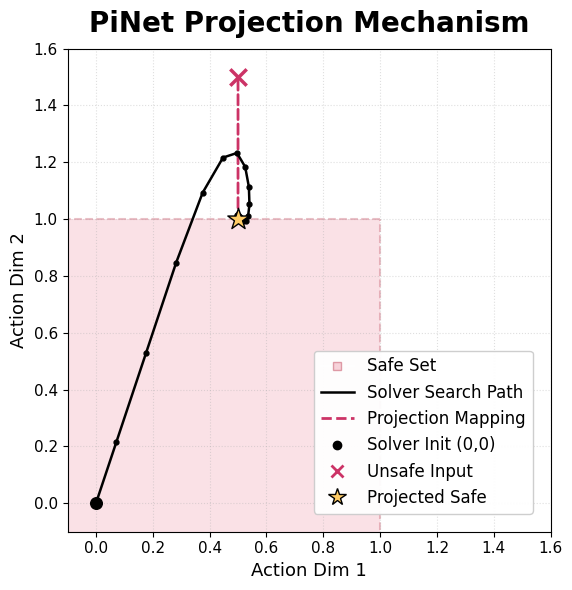

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, FancyArrowPatch
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull, HalfspaceIntersection
from scipy.optimize import linprog
from pathlib import Path

# ==========================================
# Geometry helper
# ==========================================

def get_polytope_polygon(A, b, interior_point=None):
    if isinstance(A, torch.Tensor): A = A.detach().cpu().numpy()
    if isinstance(b, torch.Tensor): b = b.detach().cpu().numpy()

    if A.ndim > 2: A = A[0]
    if b.ndim > 1: b = b[0]

    valid_mask = np.isfinite(b)
    A = A[valid_mask]
    b = b[valid_mask]

    if len(b) == 0:
        return None

    norm_A = np.linalg.norm(A, axis=1)
    c_obj = np.zeros(A.shape[1] + 1)
    c_obj[-1] = -1

    A_ub = np.hstack([A, norm_A[:, np.newaxis]])
    res = linprog(c_obj, A_ub=A_ub, b_ub=b, bounds=(None, None), method="highs")

    if res.success and res.x[-1] > 1e-6:
        interior_point = res.x[:-1]
    elif interior_point is None:
        interior_point = np.zeros(A.shape[1])

    halfspaces = np.hstack((A, -b[:, np.newaxis]))

    try:
        hs = HalfspaceIntersection(halfspaces, interior_point)
        vertices = hs.intersections
        hull = ConvexHull(vertices)
        ordered_vertices = vertices[hull.vertices]
        return Polygon(ordered_vertices, closed=True)
    except Exception:
        return None

# ==========================================
# Robust loader
# ==========================================

def load_list_data(filepath):
    path = Path(filepath)
    if not path.exists():
        for p in [Path("../" + path.name), Path(path.name)]:
            if p.exists():
                path = p
                break
        else:
            print(f"File not found: {filepath}")
            return None

    data = torch.load(path, map_location="cpu", weights_only=False)
    if not isinstance(data, list):
        data = [data]
    return data

# ==========================================
# Plot
# ==========================================

def plot_pinet_projection(filepath, step_idx=0, save=True):
    data_list = load_list_data(filepath)
    if not data_list:
        return

    data = data_list[min(step_idx, len(data_list)-1)]

    traj = data["trajectory"]
    unsafe = data["unsafe_action"]

    if traj.ndim == 3:
        traj = traj[:, 0, :]
    if unsafe.ndim == 2:
        unsafe = unsafe[0]

    traj = traj.detach().cpu().numpy()
    unsafe = unsafe.detach().cpu().numpy()

    start = traj[0]
    end = traj[-1]

    # --- Colors ---
    safe_fill = "#f3b6c2"
    safe_edge = "#cc6677"
    path_color = "black"
    proj_color = "#cc3366"
    unsafe_color = "#cc3366"
    projected_color = "#ffcc66"

    fig, ax = plt.subplots(figsize=(6, 6))

    # --- Safe set ---
    poly = get_polytope_polygon(data["safe_set_A"], data["safe_set_b"], interior_point=end)
    if poly:
        poly.set_facecolor(safe_fill)
        poly.set_edgecolor(safe_edge)
        poly.set_alpha(0.4)
        poly.set_linewidth(1.5)
        poly.set_linestyle("--")
        ax.add_patch(poly)

    # --- Path ---
    ax.plot(traj[:, 0], traj[:, 1], "-o", color=path_color, lw=1.8, markersize=3.5)

    # --- Projection arrow ---
    arrow = FancyArrowPatch(
        unsafe, end,
        arrowstyle="->",
        lw=2.0,
        linestyle="--",
        color=proj_color
    )
    ax.add_patch(arrow)

    # --- Points ---
    ax.scatter(start[0], start[1], c="black", s=70, zorder=3)
    ax.scatter(unsafe[0], unsafe[1], marker="x", c=unsafe_color, s=140, linewidths=2.5, zorder=4)
    ax.scatter(end[0], end[1], marker="*", c=projected_color, edgecolors="black", s=260, zorder=5)

    # --- Labels ---
    ax.set_title("PiNet Projection Mechanism", fontsize=20, fontweight="bold", pad=12)
    ax.set_xlabel("Action Dim 1", fontsize=13)
    ax.set_ylabel("Action Dim 2", fontsize=13)
    ax.tick_params(labelsize=11)

    ax.set_aspect("equal")
    ax.set_xlim(-0.1, 1.6)
    ax.set_ylim(-0.1, 1.6)

    ax.grid(True, linestyle=":", alpha=0.4)

    # --- Legend (bigger, and moved to avoid overlap) ---
    legend_elements = [
        Line2D([0],[0], marker='s', color='w', markerfacecolor=safe_fill, markeredgecolor=safe_edge, alpha=0.6, label='Safe Set'),
        Line2D([0],[0], color='black', lw=1.8, label='Solver Search Path'),
        Line2D([0],[0], color=proj_color, lw=2.0, linestyle='--', label='Projection Mapping'),
        Line2D([0],[0], marker='o', color='black', lw=0, label='Solver Init (0,0)'),
        Line2D([0],[0], marker='x', color=unsafe_color, lw=0, markersize=9, markeredgewidth=2, label='Unsafe Input'),
        Line2D([0],[0], marker='*', color=projected_color, markeredgecolor='black', lw=0, markersize=13, label='Projected Safe'),
    ]

    ax.legend(
        handles=legend_elements,
        loc="lower right",
        bbox_to_anchor=(0.98, 0.02),   # push legend further down-right
        fontsize=12,
        framealpha=0.95
    )

    # --- Layout ---
    plt.tight_layout()

    if save:
        plt.savefig("pinet_projection_clean.png", dpi=200, bbox_inches="tight")
        plt.savefig("pinet_projection_clean.svg", bbox_inches="tight")
        print("Saved:")
        print("  pinet_projection_clean.png")
        print("  pinet_projection_clean.svg")

    plt.show()

# ==========================================
# Run
# ==========================================

plot_pinet_projection("pinet5_steps_viz_2.pt", step_idx=0)


Running PiNet Optimization...


Running FSNet Optimization...
Saved: combined_optimization_magma.png & .svg


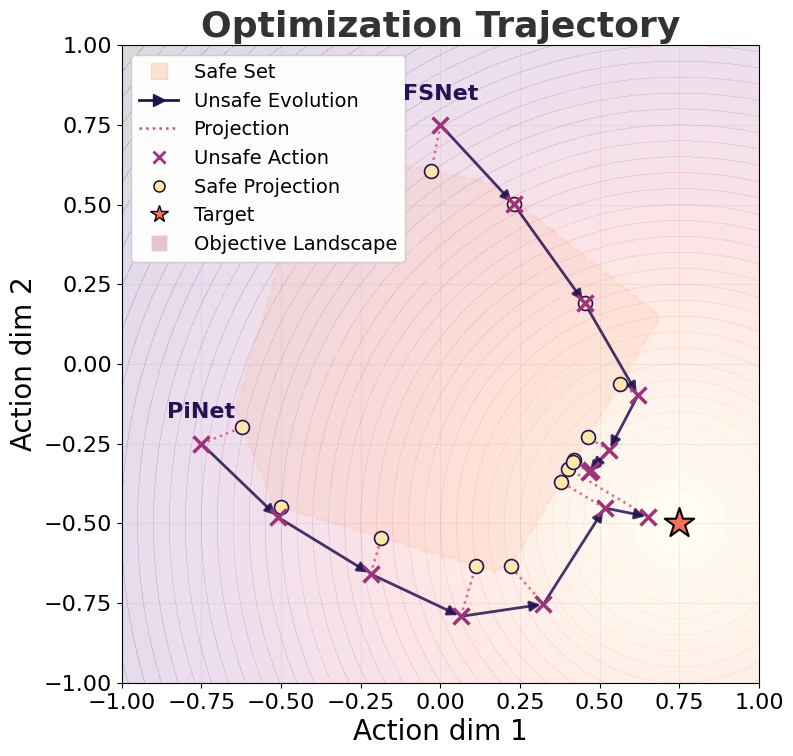

In [2]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, FancyArrowPatch
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull, HalfspaceIntersection
from scipy.optimize import linprog

# ==========================================
# Path setup
# ==========================================
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

# Imports
try:
    from safeguards.pinet import PinetSafeguard
    from safeguards.fsnet import FSNetSafeguard
    from envs.interfaces.safe_action_env import SafeActionEnv
    from envs.simulators.interfaces.simulator import Simulator
    import src.sets as sets
except ImportError as e:
    print(f"Import Error: {e}. Ensure project structure is correct.")

# ==========================================
# Helper: Automatic Polytope Visualization
# ==========================================
def get_polytope_patch(A, b, color):
    if isinstance(A, torch.Tensor): A = A.detach().cpu().numpy()
    if isinstance(b, torch.Tensor): b = b.detach().cpu().numpy()
    
    norm_A = np.linalg.norm(A, axis=1)
    c_obj = np.zeros(A.shape[1] + 1)
    c_obj[-1] = -1 
    A_ub = np.hstack([A, norm_A[:, np.newaxis]])
    b_ub = b
    res = linprog(c_obj, A_ub=A_ub, b_ub=b_ub, bounds=(None, None), method='highs')
    
    interior_point = np.zeros(A.shape[1])
    if res.success:
        interior_point = res.x[:-1]
    
    halfspaces = np.hstack((A, -b[:, np.newaxis]))
    try:
        hs = HalfspaceIntersection(halfspaces, interior_point)
        hull = ConvexHull(hs.intersections)
        ordered_vertices = hs.intersections[hull.vertices]
        return Polygon(
            ordered_vertices, closed=True,
            fc=color, alpha=0.12, ec=color, lw=2.5, ls='--', label='Safe Set'
        )
    except Exception:
        return None

# ==========================================
# Environment
# ==========================================
class ComplexPolytopeEnv(Simulator, SafeActionEnv):
    def __init__(self):
        SafeActionEnv.__init__(self, num_action_gens=2)
        num_envs = 1
        action_dim = 2
        self.polytope = True
        self.safe_action_polytope = True
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        A = [
            [ 1.0,  0.2], [ 0.8,  1.0], [ 0.2,  1.0], [-0.4,  1.0],
            [-1.0,  0.3], [-1.0, -0.4], [-0.3, -1.0], [ 0.3, -1.0],
            [ 1.0, -0.6], [ 1.0,  0.0], [ 0.6,  0.6], [-0.6,  0.6],
        ]
        b = [0.9, 0.7, 0.6, 0.7, 0.6, 0.7, 0.6, 0.7, 0.6, 0.8, 0.9, 0.9]

        self.A = torch.tensor(A, dtype=torch.float32, device=self.device)
        self.b = torch.tensor(b, dtype=torch.float32, device=self.device)

        box = sets.AxisAlignedBox(
            torch.zeros((num_envs, 2), device=self.device),
            torch.eye(2, device=self.device).unsqueeze(0)
        )
        Simulator.__init__(
            self, action_dim=action_dim,
            state_set=box, noise_set=box, observation_set=box,
            num_envs=num_envs
        )

    def compute_A_b(self): return self.A.unsqueeze(0), self.b.unsqueeze(0)
    def safe_action_set(self): return sets.Polytope(self.A.unsqueeze(0), self.b.unsqueeze(0))
    def reward(self, action): return torch.zeros(1, device=self.device)
    def episode_ending(self): return torch.zeros(1, dtype=torch.bool), torch.zeros(1, dtype=torch.bool)
    def unbatched_dynamics(self, s, a, n): return s
    def render(self): return []

# ==========================================
# Optimization Functions
# ==========================================

def run_pinet_optimization(env, target):
    device = env.device
    pinet = PinetSafeguard(
        env=env,
        regularisation_coefficient=1.0,
        n_iter_admm=20, 
        n_iter_bwd=10,
        bwd_method="unroll"
    )
    # Start Point for PiNet
    u_param = torch.tensor([[-0.75, -0.25]], requires_grad=True, dtype=torch.float32, device=device)
    
    optimizer = torch.optim.Adam([u_param], lr=0.01, betas=(0.9, 0.999))
    u_hist, s_hist = [], []
    steps = 200 # Faster convergence usually
    
    print("Running PiNet Optimization...")
    for i in range(steps):
        u_hist.append(u_param.detach().cpu().numpy().copy()[0])
        u_safe = pinet.safeguard(u_param.float())
        s_hist.append(u_safe.detach().cpu().numpy().copy()[0])
        
        diff = u_safe - target
        loss = torch.norm(diff, p=2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.array(u_hist), np.array(s_hist)

def run_fsnet_optimization(env, target):
    device = env.device
    fsnet_config = {
        "max_diff_iter": 20, "max_iter": 20, "gradient_clipping_max_norm": 1.0,
        "lbfgs_torch_learning_rate": 1.0, "lbfgs_history_size": 10,
        "objective_scale": 1.0, "convergence_value_tolerance": 1e-6,
        "convergence_gradient_tolerance": 1e-6, "line_search_max_iter": 10,
        "line_search_armijo_c": 1e-4, "line_search_rho": 0.5, "verbose": False
    }
    fsnet = FSNetSafeguard(env=env, regularisation_coefficient=1.0, **fsnet_config)
    
    # Start Point for FSNet (Different from PiNet)
    u_param = torch.tensor([[0.00, 0.75]], requires_grad=True, dtype=torch.float32, device=device)
    
    optimizer = torch.optim.Adam([u_param], lr=0.01, betas=(0.9, 0.999))
    u_hist, s_hist = [], []
    steps = 150
    
    print("Running FSNet Optimization...")
    for i in range(steps):
        u_hist.append(u_param.detach().cpu().numpy().copy()[0])
        u_safe = fsnet.safeguard(u_param.float())
        s_hist.append(u_safe.detach().cpu().numpy().copy()[0])
        
        diff = u_safe - target
        loss = torch.norm(diff, p=2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.array(u_hist), np.array(s_hist)

# ==========================================
# Combined Visualization
# ==========================================
def plot_combined_results(pinet_data, fsnet_data, target, env):
    # Unpack data
    u_pinet, s_pinet = pinet_data
    u_fsnet, s_fsnet = fsnet_data

    cmap = plt.get_cmap('magma')
    c_path_dark  = cmap(0.15)
    c_unsafe_pt  = cmap(0.45)
    c_proj_link  = cmap(0.60)
    c_safe_set   = cmap(0.80)
    c_target     = cmap(0.70)
    c_safe_pt    = cmap(0.95)

    fig, ax = plt.subplots(figsize=(8, 8))
    
    # --- 1. Background: Objective Landscape ---
    x_range = np.linspace(-1.0, 1.2, 200)
    y_range = np.linspace(-1.0, 1.2, 200)
    XX, YY = np.meshgrid(x_range, y_range)
    Z = np.sqrt((XX - target[0])**2 + (YY - target[1])**2)
    ax.contourf(XX, YY, -Z, levels=50, cmap='magma', alpha=0.15, zorder=0)
    ax.contour(XX, YY, Z, levels=15, colors='white', alpha=0.1, linewidths=0.5, zorder=0)

    # --- 2. Safe Set ---
    poly_patch = get_polytope_patch(env.A, env.b, color=c_safe_set)
    if poly_patch:
        ax.add_patch(poly_patch)

    # --- 3. Plot Function (Helper) ---
    def plot_trajectory(u_traj, s_traj, label_text):
        indices = [0, 24, 49, 74, 99, 124, 149]
        # Label near start point
        if len(u_traj) > 0:
            start_pt = u_traj[0]
            ax.text(start_pt[0], start_pt[1] + 0.08, label_text, 
                    fontsize=16, fontweight='bold', color=c_path_dark, 
                    ha='center', zorder=20)

        for k, i in enumerate(indices):
            if i >= len(u_traj): break
            u, s = u_traj[i], s_traj[i]
            
            # Evolution Arrow
            if k < len(indices) - 1:
                u_next = u_traj[indices[k+1]]
                arrow = FancyArrowPatch(
                    posA=u, posB=u_next,
                    arrowstyle='-|>,head_length=6,head_width=3',
                    connectionstyle="arc3,rad=0", 
                    color=c_path_dark, lw=2, alpha=0.85, zorder=3
                )
                ax.add_patch(arrow)

            # Projection Link
            ax.plot([u[0], s[0]], [u[1], s[1]],
                    linestyle=':', color=c_proj_link, lw=1.8, alpha=0.8, zorder=2)

            # Markers
            ax.plot(u[0], u[1], marker='x', ms=12, color=c_unsafe_pt, mew=2.5, zorder=5)
            ax.plot(s[0], s[1], marker='o', ms=10, color=c_safe_pt, mec=c_path_dark, mew=1.2, zorder=4)

    # Plot both
    plot_trajectory(u_pinet, s_pinet, "PiNet")
    plot_trajectory(u_fsnet, s_fsnet, "FSNet")

    # --- 4. Target ---
    ax.scatter(target[0], target[1], marker='*', s=500,
               color=c_target, edgecolors='black', lw=1.5, label='Target', zorder=10)

    # --- 5. Formatting ---
    ax.set_xlim(-1.00, 1.00)
    ax.set_ylim(-1.00, 1.00)
    ax.set_aspect('equal')
    ax.set_title("Optimization Trajectory", fontsize=26, fontweight='bold', color='#333333')
    ax.set_xlabel("Action dim 1", fontsize=20)
    ax.set_ylabel("Action dim 2", fontsize=20)
    ax.tick_params(labelsize=16)
    ax.grid(True, linestyle='-', alpha=0.1, color='gray')

    # Legend
    legend_elements = [
        Line2D([0], [0], color='white', marker='s', markerfacecolor=c_safe_set,
               alpha=0.3, markersize=12, markeredgecolor=c_safe_set,
               linestyle='--', lw=2, label='Safe Set'),
        Line2D([0], [0], color=c_path_dark, lw=2, marker='>', markersize=8,
               label='Unsafe Evolution'),
        Line2D([0], [0], color=c_proj_link, lw=1.8, linestyle=':',
               label='Projection'),
        Line2D([0], [0], marker='x', color=c_unsafe_pt, lw=0, markersize=9,
               markeredgewidth=2, label='Unsafe Action'),
        Line2D([0], [0], marker='o', color=c_safe_pt, markeredgecolor='black',
               lw=0, markersize=8, label='Safe Projection'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor=c_target,
               markeredgecolor='black', markersize=13, label='Target'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor=cmap(0.5), 
               alpha=0.3, markersize=12, label='Objective Landscape'),
    ]

    # --- FIX: Changed loc to 'upper left' ---
    ax.legend(handles=legend_elements, loc='upper left', framealpha=0.95, fontsize=14)

    plt.tight_layout()
    plt.savefig("combined_optimization_magma.png", dpi=300, bbox_inches='tight')
    plt.savefig("combined_optimization_magma.svg", bbox_inches='tight')
    print("Saved: combined_optimization_magma.png & .svg")
    plt.show()

# ==========================================
# Run Main
# ==========================================
if __name__ == "__main__":
    env = ComplexPolytopeEnv()
    target = torch.tensor([[0.75, -0.50]], dtype=torch.float32, device=env.device)
    
    # Run Both Optimizations
    pinet_res = run_pinet_optimization(env, target)
    fsnet_res = run_fsnet_optimization(env, target)
    
    # Plot Combined
    plot_combined_results(pinet_res, fsnet_res, target.cpu().numpy()[0], env)